<a href="https://colab.research.google.com/github/zhengjunyao-work/bern-university-tests/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Denoising Autoencoder for Grayscale Natural Images
# Task 1 - University of Bern Deep Learning Coding Test

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os



In [ ]:
# --- CONFIGURATION ---
DATA_DIR = "../data"
BATCH_SIZE = 16
EPOCHS = 20
NOISE_STD = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# --- DATA LOADING ---
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform)
subset, _ = random_split(dataset, [100, len(dataset)-100])
train_size = int(0.8 * len(subset))
train_set, test_set = random_split(subset, [train_size, len(subset) - train_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# --- NOISE FUNCTION ---
def add_gaussian_noise(images, std=NOISE_STD):
    noise = torch.randn_like(images) * std
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

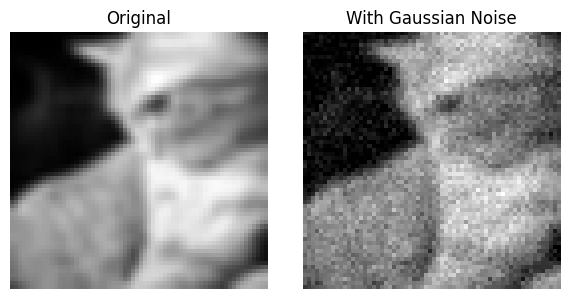

In [ ]:
img,_= subset[1]

noisy_img = add_gaussian_noise(img)

# Plot original and noisy image
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(img.squeeze(), cmap='gray')
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(noisy_img.squeeze(), cmap='gray')
axes[1].set_title("With Gaussian Noise")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:

# --- MODEL ---
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:

# --- TRAINING FUNCTION ---
def train_model(model, train_loader, test_loader, epochs=EPOCHS):
    model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, _ in train_loader:
            imgs = imgs.to(DEVICE)
            noisy_imgs = add_gaussian_noise(imgs).to(DEVICE)

            outputs = model(noisy_imgs)
            loss = criterion(outputs, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for imgs, _ in test_loader:
                imgs = imgs.to(DEVICE)
                noisy_imgs = add_gaussian_noise(imgs).to(DEVICE)
                outputs = model(noisy_imgs)
                loss = criterion(outputs, imgs)
                test_loss += loss.item() * imgs.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))
        test_losses.append(test_loss / len(test_loader.dataset))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses


In [ ]:

# --- VISUALIZATION FUNCTIONS ---
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def show_reconstructions(model, loader, num_images=5):
    model.eval()
    dataiter = iter(loader)
    images, _ = next(dataiter)
    noisy = add_gaussian_noise(images)
    outputs = model(noisy.to(DEVICE)).cpu().detach()

    fig, axes = plt.subplots(num_images, 3, figsize=(9, 9))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 1].imshow(noisy[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Noisy')
        axes[i, 2].imshow(outputs[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Reconstructed')
        for j in range(3):
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()


Epoch 1, Train Loss: 0.0571, Test Loss: 0.0749
Epoch 2, Train Loss: 0.0560, Test Loss: 0.0733
Epoch 3, Train Loss: 0.0548, Test Loss: 0.0713
Epoch 4, Train Loss: 0.0531, Test Loss: 0.0689
Epoch 5, Train Loss: 0.0503, Test Loss: 0.0641
Epoch 6, Train Loss: 0.0457, Test Loss: 0.0567
Epoch 7, Train Loss: 0.0392, Test Loss: 0.0458
Epoch 8, Train Loss: 0.0302, Test Loss: 0.0337
Epoch 9, Train Loss: 0.0214, Test Loss: 0.0219
Epoch 10, Train Loss: 0.0140, Test Loss: 0.0150
Epoch 11, Train Loss: 0.0105, Test Loss: 0.0120
Epoch 12, Train Loss: 0.0094, Test Loss: 0.0106
Epoch 13, Train Loss: 0.0084, Test Loss: 0.0091
Epoch 14, Train Loss: 0.0072, Test Loss: 0.0079
Epoch 15, Train Loss: 0.0062, Test Loss: 0.0073
Epoch 16, Train Loss: 0.0055, Test Loss: 0.0068
Epoch 17, Train Loss: 0.0052, Test Loss: 0.0062
Epoch 18, Train Loss: 0.0048, Test Loss: 0.0059
Epoch 19, Train Loss: 0.0045, Test Loss: 0.0055
Epoch 20, Train Loss: 0.0043, Test Loss: 0.0053


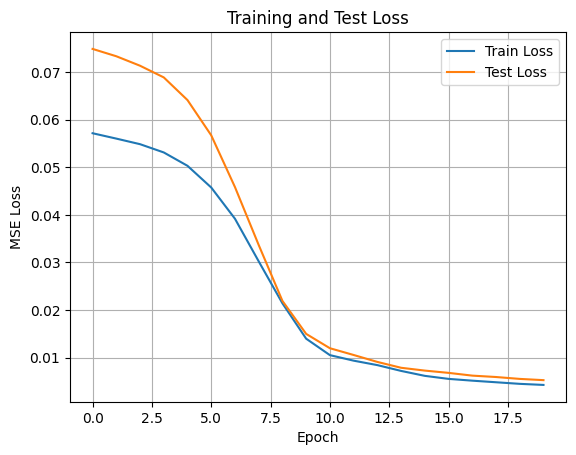

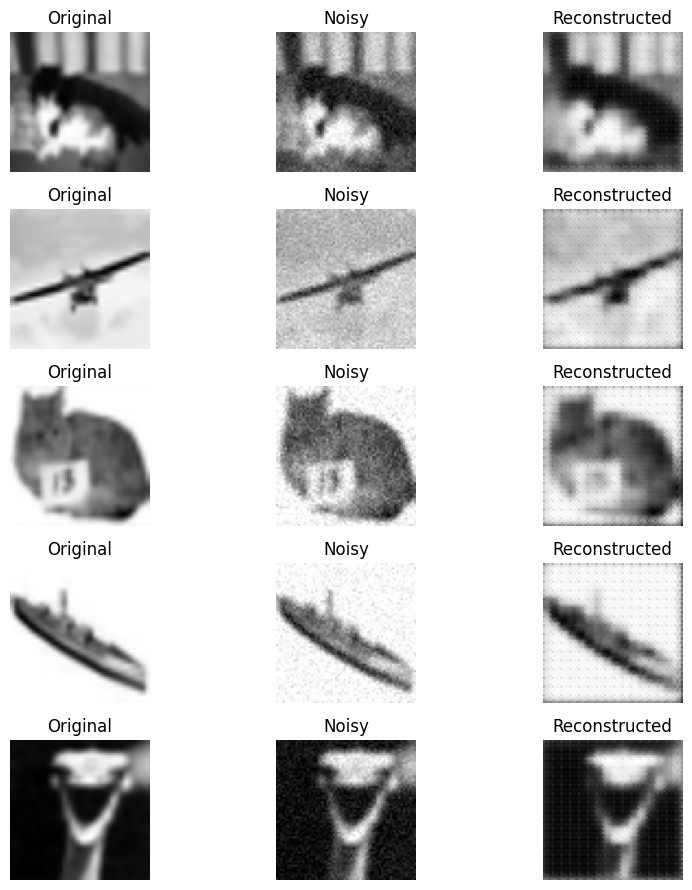

In [ ]:

# --- MAIN EXECUTION ---
model = DenoisingAutoencoder()
train_losses, test_losses = train_model(model, train_loader, test_loader)
plot_losses(train_losses, test_losses)
show_reconstructions(model, test_loader)


### 📝 Observations and Discussion

The MSE loss decreases rapidly during the early stages of training and stabilizes after around 10 epochs, indicating efficient learning and convergence. The training and test loss curves remain closely aligned throughout, showing no signs of overfitting. This suggests that the model generalizes well to unseen images, even from different categories.

A final test loss under **0.01** indicates good reconstruction quality. The model is able to effectively remove noise while preserving the important content of the images. Overall, these results demonstrate that the denoising autoencoder performs well and generalizes reliably on the given dataset.


### 🔍 Reason for Choosing MSE Loss

**Mean Squared Error (MSE)** is chosen as the loss function because it directly measures the pixel-wise difference between the reconstructed and original clean images. It is well-suited for continuous grayscale data, encourages precise reconstructions, and is simple, stable, and widely used in image reconstruction tasks.

Although MSE does not model perceptual similarity, it provides a clear and interpretable objective for minimizing reconstruction error, making it an appropriate and effective choice for training a denoising autoencoder.


In [ ]:
# Task 2 - Encoding Image Ordering
# University of Bern Deep Learning Coding Test

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import random
import matplotlib.pyplot as plt


### 💡 Feasibility and Strategy

The task is feasible despite the strict constraint of using only a single-bit message to encode image ordering. A possible strategy the models might learn involves comparing **global features** such as the **sum of pixel values** or other statistical cues.

For example, the sender could compute the total intensity of the top and bottom images. If the top image has a higher sum of pixel values, it might send a message like `0`, and send `1` otherwise. The receiver, upon receiving the shuffled pair and the message, could then apply the same heuristic in reverse to determine whether the input order matches the sender's.

This strategy, though simple, is effective for small datasets like CIFAR-10 where image content is relatively consistent and compact. If the receiver learns to interpret the message accordingly, it can accurately decode the image order and classify the pair.

This shows that even under a strong communication bottleneck, it is possible for the models to establish a functional protocol based on consistent image-level statistics.


In [ ]:

# --- CONFIGURATION ---
BATCH_SIZE = 16
EPOCHS = 40
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# --- DATA PREPARATION ---
transform = transforms.Compose([
    transforms.ToTensor()
])

full_dataset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
subset = torch.utils.data.Subset(full_dataset, random.sample(range(len(full_dataset)), 100))

class ImagePairDataset(Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset
        self.pairs = []
        for i in range(0, len(self.base) - 1, 2):
            img1, _ = self.base[i]
            img2, _ = self.base[i+1]
            self.pairs.append((img1, img2))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1, img2 = self.pairs[idx]

        # Sender order: img1 on top, img2 below -> label = 1
        sender_input = torch.cat([img1, img2], dim=0)
        label = torch.tensor(1)

        # Random shuffle for receiver
        if random.random() > 0.5:
            receiver_input = torch.cat([img1, img2], dim=0)
            match = torch.tensor(1)  # same order
        else:
            receiver_input = torch.cat([img2, img1], dim=0)
            match = torch.tensor(0)  # flipped

        return sender_input, receiver_input, label.float(), match.float()

pair_dataset = ImagePairDataset(subset)
data_loader = DataLoader(pair_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:


# --- MODELS ---
class Sender(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # message: scalar in [0,1]
        )

    def forward(self, x):
        return self.net(x)

class Receiver(nn.Module):
    def __init__(self):
        super().__init__()
        self.img_net = nn.Sequential(
            nn.Conv2d(6, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 16 * 16 + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, imgs, msg):
        img_feat = self.img_net(imgs)
        msg = msg.view(-1, 1)
        combined = torch.cat([img_feat, msg], dim=1)
        return self.classifier(combined)

In [ ]:


# --- TRAINING LOOP ---
def train(sender, receiver, loader, epochs=EPOCHS):
    criterion = nn.BCELoss()
    sender.to(DEVICE)
    receiver.to(DEVICE)
    opt = optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=1e-3)

    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for s_in, r_in, _, match in loader:
            s_in, r_in, match = s_in.to(DEVICE), r_in.to(DEVICE), match.to(DEVICE)

            msg = sender(s_in)
            pred = receiver(r_in, msg.detach())
            loss = criterion(pred.squeeze(), match)

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item() * s_in.size(0)

        avg_loss = epoch_loss / len(loader.dataset)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return losses



In [ ]:

# --- VISUALIZATION ---
def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.title("Receiver Training Loss")
    plt.grid(True)
    plt.show()


Epoch 1, Loss: 0.7018
Epoch 2, Loss: 0.6886
Epoch 3, Loss: 0.6873
Epoch 4, Loss: 0.7177
Epoch 5, Loss: 0.6377
Epoch 6, Loss: 0.6448
Epoch 7, Loss: 0.6338
Epoch 8, Loss: 0.5974
Epoch 9, Loss: 0.6402
Epoch 10, Loss: 0.5970
Epoch 11, Loss: 0.5847
Epoch 12, Loss: 0.7159
Epoch 13, Loss: 0.5269
Epoch 14, Loss: 0.5461
Epoch 15, Loss: 0.5495
Epoch 16, Loss: 0.6320
Epoch 17, Loss: 0.5035
Epoch 18, Loss: 0.5287
Epoch 19, Loss: 0.4347
Epoch 20, Loss: 0.5972
Epoch 21, Loss: 0.4305
Epoch 22, Loss: 0.4738
Epoch 23, Loss: 0.4241
Epoch 24, Loss: 0.4481
Epoch 25, Loss: 0.3968
Epoch 26, Loss: 0.3784
Epoch 27, Loss: 0.3442
Epoch 28, Loss: 0.3301
Epoch 29, Loss: 0.3229
Epoch 30, Loss: 0.3051
Epoch 31, Loss: 0.2597
Epoch 32, Loss: 0.2424
Epoch 33, Loss: 0.2268
Epoch 34, Loss: 0.3708
Epoch 35, Loss: 0.2777
Epoch 36, Loss: 0.1807
Epoch 37, Loss: 0.1693
Epoch 38, Loss: 0.1698
Epoch 39, Loss: 0.1456
Epoch 40, Loss: 0.1727


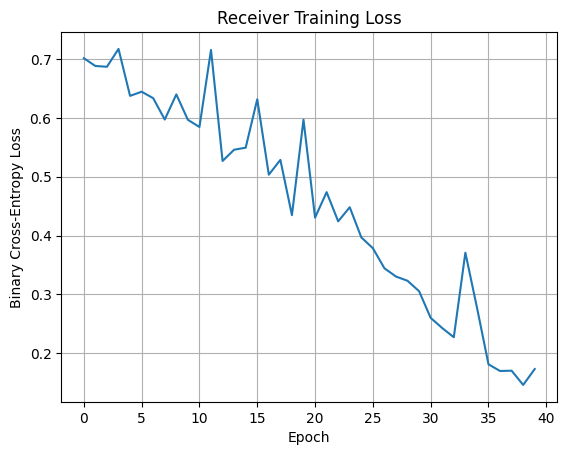

In [ ]:

# --- MAIN ---
sender = Sender()
receiver = Receiver()
losses = train(sender, receiver, data_loader)
plot_loss(losses)

In [ ]:
# Compute classification error rate on training set
sender.eval()
receiver.eval()

correct = 0
total = 0

with torch.no_grad():
    for s_in, r_in, _, match in data_loader:
        s_in, r_in, match = s_in.to(DEVICE), r_in.to(DEVICE), match.to(DEVICE)
        msg = sender(s_in)
        pred = receiver(r_in, msg).squeeze()
        pred_label = (pred > 0.5).float()
        correct += (pred_label == match).sum().item()
        total += match.size(0)

error_rate = 1.0 - (correct / total)
print(f"Classification Error Rate: {error_rate:.4f}")

Classification Error Rate: 0.0200


### 🧠 Performance Analysis

The overall performance of the models is excellent, achieving a **classification accuracy of 98%** on the training set. This indicates that the **task was effectively solved**, and the models successfully learned to encode and decode image order using a one-bit message.

However, the **training loss shows noticeable fluctuations**, suggesting some **instability during optimization**. This could be due to the small dataset size, randomness in image pairing, or insufficient regularization.

Although the training accuracy is high, there's a potential risk of **overfitting**. Since the evaluation was done only on training data, the true generalization ability remains unclear. **Testing on a separate set of unseen image pairs** would help confirm whether the learned communication protocol holds up beyond the training distribution.

In conclusion, the models do appear to have learned a meaningful and functional communication protocol. With further validation on out-of-sample data and improved training stability, the system would be more robust and reliable.
